In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import math

In [2]:
def graph_json(filename):
    with open(filename) as json_file:
        json_data = json.load(json_file)
        name = json_data['ObjectName']
        seed = json_data['Seed']
        deformed_deviation = json_data['DeformedAngularDeviation']
        deformation_method = json_data['DeformationMethod']
        offsets = np.array(json_data['Offsets'], dtype='float')
        vertices = np.array(json_data['Vertices'], dtype='int')
        skipped_iterations = np.array(json_data['SkippedIterations'], dtype='bool')
        ideal_normal_angles_from_ray = np.array(json_data['IdealNormalAnglesFromRay'], dtype='float')
        iterations = vertices.size
        deviations = np.array(json_data['Deviations'], dtype='float').reshape((iterations, offsets.size))

        min_deviation = np.min(deviations[-1])
        max_deviation = np.max(deviations)
        min_offset = np.round(np.min(offsets), 2)
        max_offset = np.round(np.max(offsets), 2)
        effective_iterations = iterations - np.sum(skipped_iterations)

        deviation_diff_percent = (min_deviation-deformed_deviation)/deformed_deviation * 100

        title = f"{name} total angular deviation (0; {np.round(max_deviation,2)}) per offset ({min_offset}; {max_offset})"
        title += f"\n {iterations} iterations plotted ltr-ttb. {effective_iterations} iterations ({np.round(effective_iterations/iterations*100, 2)}%) reduced the minimum"
        title += f"\n Total angular deviation reduced from {np.round(deformed_deviation, 2)} to {np.round(min_deviation, 2)} ({np.round(deviation_diff_percent, 2)}%)"
        title += f"\n Deformation method: {deformation_method}"
        if (deformation_method == "Random"):
            title += f" (seed {seed})"
        print(title)

        xplots = 10
        yplots = math.ceil(iterations/xplots)
        fig, axs = plt.subplots(yplots, xplots, figsize=(12, yplots*1.5))

        for y in range(yplots):
            for x in range(xplots):
                iter = y*xplots + x
                if iter < iterations:
                    color = 'red' if skipped_iterations[iter] else 'blue'
                    axs[y,x].plot(offsets, deviations[iter], c=color)
                    vertex = vertices[iter]
                    axs[y,x].set_title(f"v: {vertex} - a: {np.round(ideal_normal_angles_from_ray[vertex],1)}")

                axs[y,x].set_ylim(0, max_deviation)
                axs[y,x].set_xticklabels([])
                axs[y,x].set_yticklabels([])
        
        fig.tight_layout()
        fig.show()

Tetrahedron total angular deviation (0; 1327.14) per offset (-10.0; 9.9)
 49 iterations plotted ltr-ttb. 7 iterations (14.29%) reduced the minimum
 Total angular deviation reduced from 96.37 to 10.5 (-89.1%)
 Deformation method: Random (seed 0)


/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_6327/3226028735.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


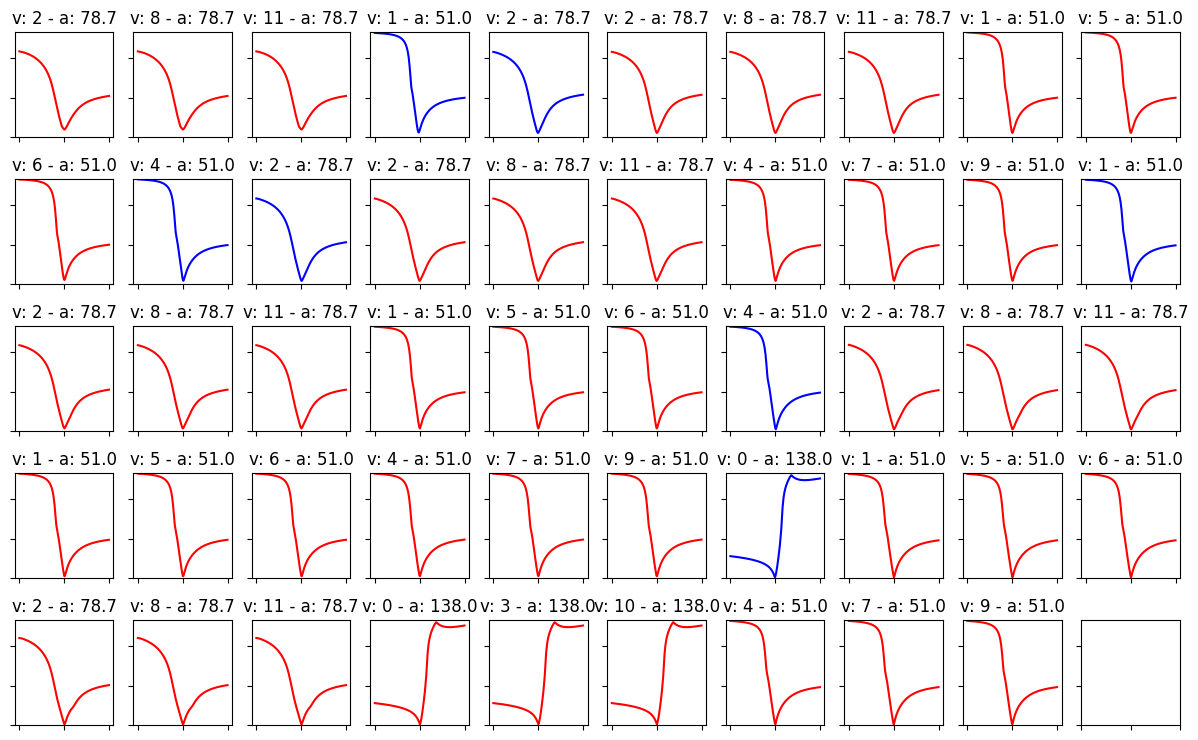

In [3]:
graph_json("Tetrahedron.json")

Cube total angular deviation (0; 1362.98) per offset (-10.0; 9.9)
 60 iterations plotted ltr-ttb. 12 iterations (20.0%) reduced the minimum
 Total angular deviation reduced from 123.66 to 13.24 (-89.29%)
 Deformation method: Random (seed 0)


/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_6327/3226028735.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


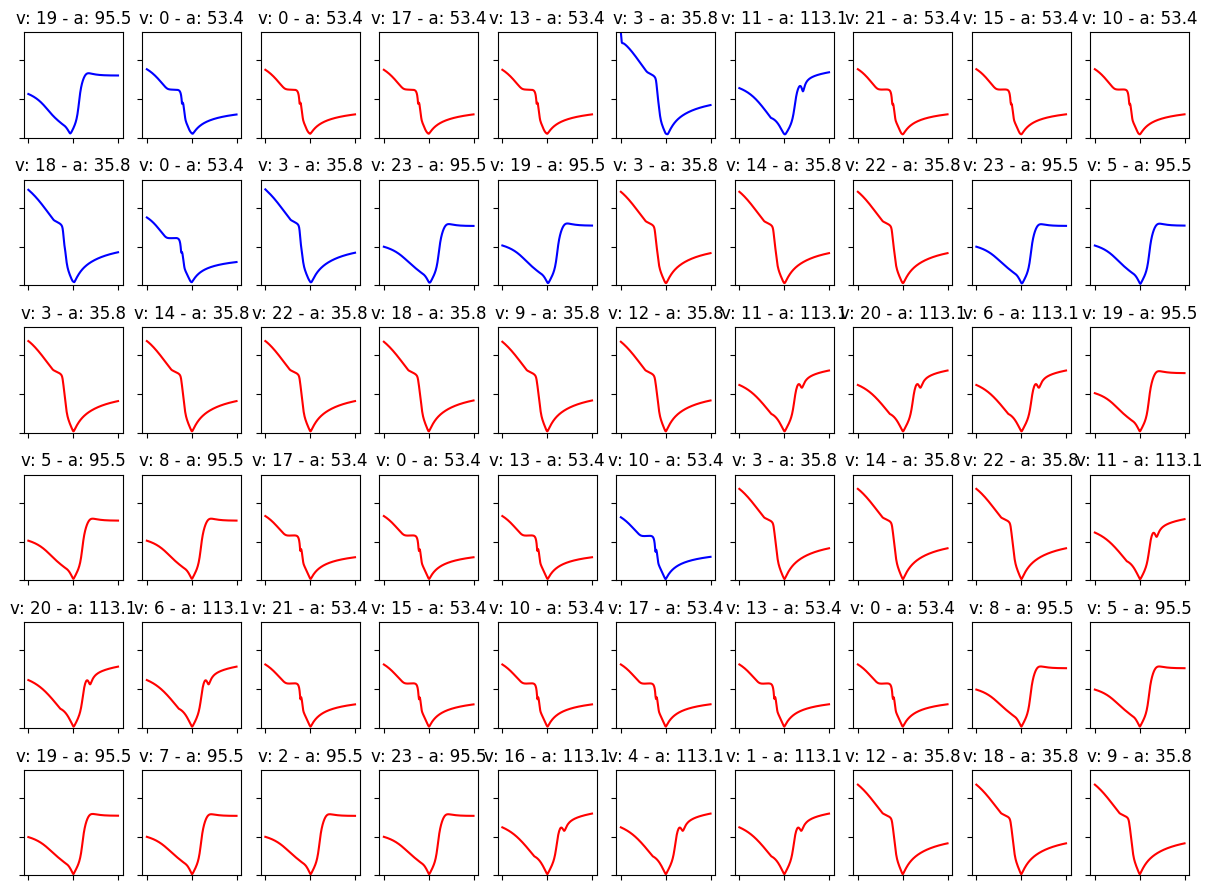

In [4]:
graph_json("Cube.json")

Icosahedron total angular deviation (0; 2397.98) per offset (-10.0; 9.9)
 515 iterations plotted ltr-ttb. 25 iterations (4.85%) reduced the minimum
 Total angular deviation reduced from 733.05 to 222.47 (-69.65%)
 Deformation method: Random (seed 0)


/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_6327/3226028735.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


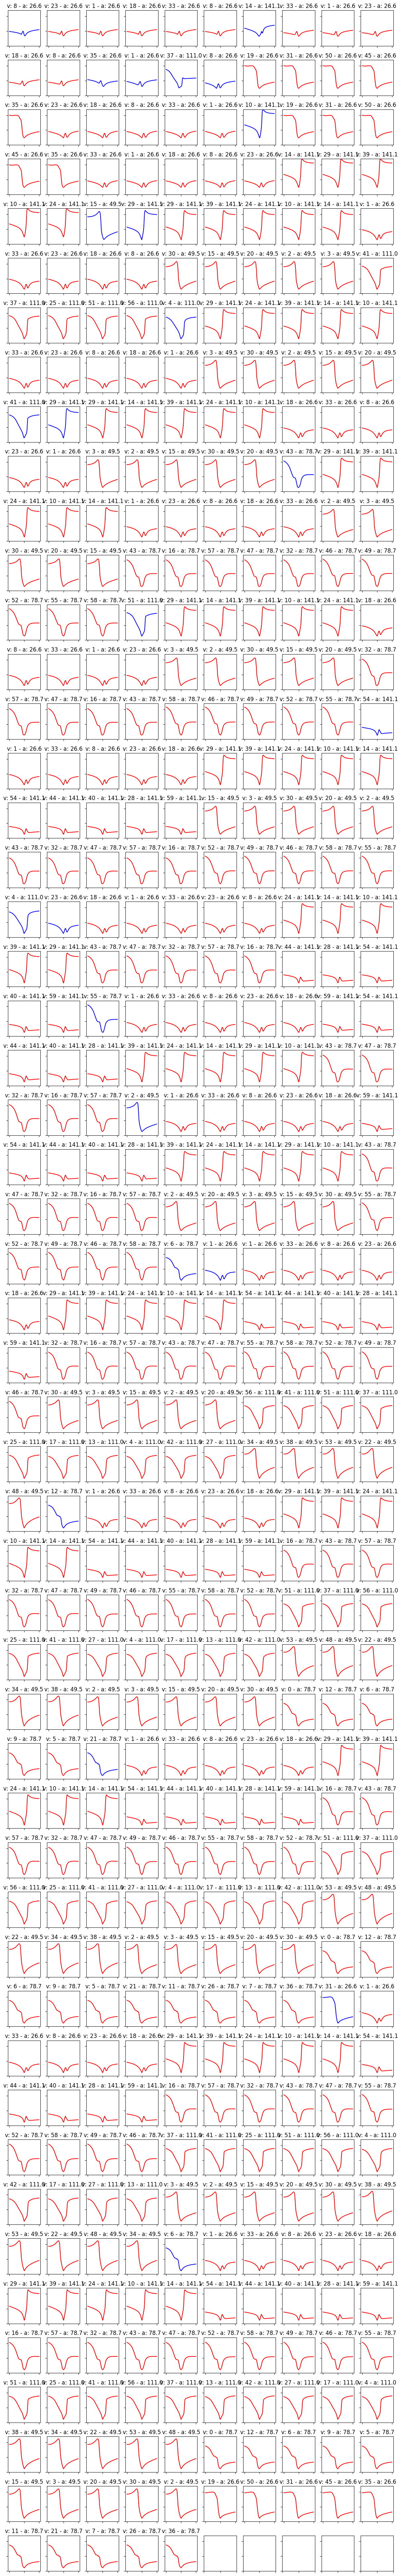

In [5]:
graph_json("Icosahedron.json")